In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.19.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nw_lao4h
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-nw_lao4h
  Resolved https://github.com/tensorflow/docs to commit 1a48d77bcc518865e7dfb3fd87bb75e7747bdc78
  Preparing metadata (setup.py) ... done
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (2.1 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.24.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.25.1-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (4.1 kB)
Using cached jinja2-3.1.6-py3

In [3]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp()) / "tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file(
    "HIGGS.csv.gz", "http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz"
)

2816407858/2816407858 ━━━━━━━━━━━━━━━━━━━━ 444s 0us/step


In [6]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(
    gz,
    [
        float(),
    ]
    * (FEATURES + 1),
    compression_type="GZIP",
)

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


2025-07-01 22:02:43.656362: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


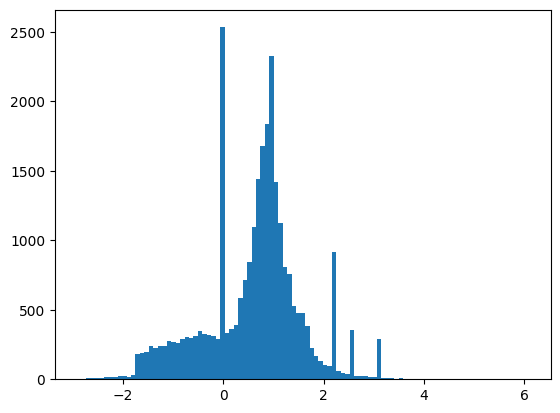

In [9]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [10]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [11]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [12]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [ ]:
# 학습률 스케줄링(Learning Rate Scheduling)을 사용하여 Adam 옵티마이저를 구성
# 시간이 지남에 따라 학습률이 천천히 감소
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=STEPS_PER_EPOCH * 1000, decay_rate=1, staircase=False
)


def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

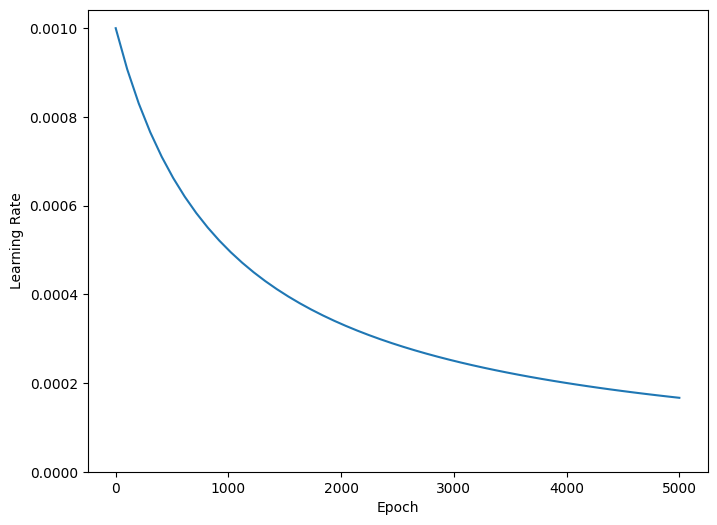

In [14]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

In [15]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy", patience=200
        ),
        tf.keras.callbacks.TensorBoard(logdir / name),
    ]

In [16]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.losses.BinaryCrossentropy(
                from_logits=True, name="binary_crossentropy"
            ),
            "accuracy",
        ],
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0,
    )
    return history

In [17]:
tiny_model = tf.keras.Sequential(
    [layers.Dense(16, activation="elu", input_shape=(FEATURES,)), layers.Dense(1)]
)

/home/chan/code/vscode/tensor-cpp/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
size_histories = {}

In [19]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4894,  binary_crossentropy:0.9000,  loss:0.9000,  val_accuracy:0.4890,  val_binary_crossentropy:0.5446,  val_loss:0.8169,  
.....

2025-07-01 22:07:49.513946: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/chan/code/vscode/tensor-cpp/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-07-01 22:07:49.624898: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.......

2025-07-01 22:07:49.784551: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.........

2025-07-01 22:07:50.072042: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


...............

2025-07-01 22:07:50.635079: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.................................

2025-07-01 22:07:51.675399: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


...............................
Epoch: 100, accuracy:0.5984,  binary_crossentropy:0.6250,  loss:0.6250,  val_accuracy:0.5730,  val_binary_crossentropy:0.4211,  val_loss:0.6316,  
.................................

2025-07-01 22:07:53.708765: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


...................................................................
Epoch: 200, accuracy:0.6179,  binary_crossentropy:0.6126,  loss:0.6126,  val_accuracy:0.5820,  val_binary_crossentropy:0.4126,  val_loss:0.6189,  
............................................................

2025-07-01 22:07:57.721988: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


........................................
Epoch: 300, accuracy:0.6363,  binary_crossentropy:0.6044,  loss:0.6044,  val_accuracy:0.5990,  val_binary_crossentropy:0.4103,  val_loss:0.6154,  
..................................

2025-07-01 22:08:00.136085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:15,RepeatDataset:16): Filling up shuffle buffer (this may take a while): 9999 of 10000
2025-07-01 22:08:00.136145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


..................................

2025-07-01 22:08:01.225698: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


................................
Epoch: 400, accuracy:0.6466,  binary_crossentropy:0.5962,  loss:0.5962,  val_accuracy:0.6200,  val_binary_crossentropy:0.3997,  val_loss:0.5995,  
....................................................................................................
Epoch: 500, accuracy:0.6588,  binary_crossentropy:0.5909,  loss:0.5909,  val_accuracy:0.6290,  val_binary_crossentropy:0.3960,  val_loss:0.5940,  
.................

2025-07-01 22:08:06.298382: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


...................................................................................
Epoch: 600, accuracy:0.6639,  binary_crossentropy:0.5863,  loss:0.5863,  val_accuracy:0.6530,  val_binary_crossentropy:0.3929,  val_loss:0.5894,  
....................................................................................................
Epoch: 700, accuracy:0.6676,  binary_crossentropy:0.5835,  loss:0.5835,  val_accuracy:0.6580,  val_binary_crossentropy:0.3917,  val_loss:0.5876,  
....................................................................................................
Epoch: 800, accuracy:0.6719,  binary_crossentropy:0.5805,  loss:0.5805,  val_accuracy:0.6680,  val_binary_crossentropy:0.3913,  val_loss:0.5870,  
....................................................................................................
Epoch: 900, accuracy:0.6731,  binary_crossentropy:0.5794,  loss:0.5794,  val_accuracy:0.6710,  val_binary_crossentropy:0.3910,  val_loss:0.5865,  
.........................

2025-07-01 22:08:22.741363: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


.......................................................................
Epoch: 1100, accuracy:0.6781,  binary_crossentropy:0.5759,  loss:0.5759,  val_accuracy:0.6550,  val_binary_crossentropy:0.3916,  val_loss:0.5874,  
....................................................................................................
Epoch: 1200, accuracy:0.6753,  binary_crossentropy:0.5746,  loss:0.5746,  val_accuracy:0.6700,  val_binary_crossentropy:0.3913,  val_loss:0.5869,  
....................................................................................................
Epoch: 1300, accuracy:0.6759,  binary_crossentropy:0.5737,  loss:0.5737,  val_accuracy:0.6780,  val_binary_crossentropy:0.3909,  val_loss:0.5863,  
.....................................

(0.5, 0.7)

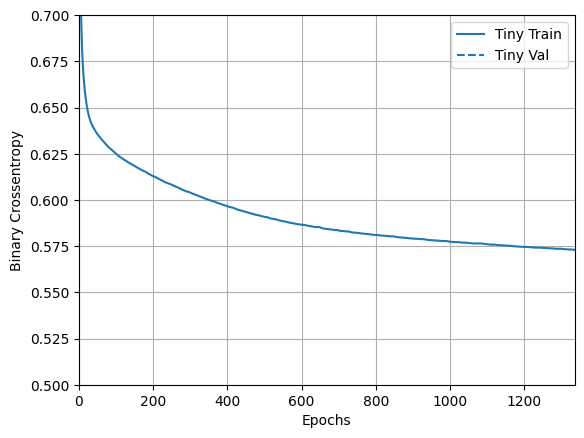

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric="binary_crossentropy", smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [21]:
small_model = tf.keras.Sequential(
    [
        # `input_shape` is only required here so that `.summary` works.
        layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
        layers.Dense(16, activation="elu"),
        layers.Dense(1),
    ]
)

In [22]:
size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4922,  binary_crossentropy:0.7212,  loss:0.7212,  val_accuracy:0.4800,  val_binary_crossentropy:0.4658,  val_loss:0.6986,  
....................................................................................................
Epoch: 100, accuracy:0.6138,  binary_crossentropy:0.6156,  loss:0.6156,  val_accuracy:0.5670,  val_binary_crossentropy:0.4163,  val_loss:0.6245,  
.............................

2025-07-01 22:09:23.115745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:15,RepeatDataset:16): Filling up shuffle buffer (this may take a while): 9999 of 10000
2025-07-01 22:09:23.115794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


........................................

2025-07-01 22:09:24.564081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


...............................
Epoch: 200, accuracy:0.6648,  binary_crossentropy:0.5864,  loss:0.5864,  val_accuracy:0.6320,  val_binary_crossentropy:0.4007,  val_loss:0.6010,  
....................................................................................................
Epoch: 300, accuracy:0.6781,  binary_crossentropy:0.5759,  loss:0.5759,  val_accuracy:0.6610,  val_binary_crossentropy:0.3986,  val_loss:0.5979,  
....................................................................................................
Epoch: 400, accuracy:0.6817,  binary_crossentropy:0.5706,  loss:0.5706,  val_accuracy:0.6660,  val_binary_crossentropy:0.3982,  val_loss:0.5973,  
....................................................................................................
Epoch: 500, accuracy:0.6885,  binary_crossentropy:0.5666,  loss:0.5666,  val_accuracy:0.6630,  val_binary_crossentropy:0.3993,  val_loss:0.5990,  
.............................................................................

In [23]:
medium_model = tf.keras.Sequential(
    [
        layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
        layers.Dense(64, activation="elu"),
        layers.Dense(64, activation="elu"),
        layers.Dense(1),
    ]
)

In [24]:
size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.4823,  binary_crossentropy:0.7054,  loss:0.7054,  val_accuracy:0.4640,  val_binary_crossentropy:0.4558,  val_loss:0.6836,  
................................................................................................

2025-07-01 22:10:10.158435: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


....
Epoch: 100, accuracy:0.7084,  binary_crossentropy:0.5366,  loss:0.5366,  val_accuracy:0.6350,  val_binary_crossentropy:0.4016,  val_loss:0.6024,  
....................................................................................................
Epoch: 200, accuracy:0.7731,  binary_crossentropy:0.4418,  loss:0.4418,  val_accuracy:0.6400,  val_binary_crossentropy:0.4562,  val_loss:0.6843,  
......................................................................................

In [25]:
large_model = tf.keras.Sequential(
    [
        layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
        layers.Dense(512, activation="elu"),
        layers.Dense(512, activation="elu"),
        layers.Dense(512, activation="elu"),
        layers.Dense(1),
    ]
)

In [26]:
size_histories["large"] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5129,  binary_crossentropy:0.8139,  loss:0.8139,  val_accuracy:0.4770,  val_binary_crossentropy:0.4571,  val_loss:0.6857,  
...........................................................................................

2025-07-01 22:11:00.935997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:15,RepeatDataset:16): Filling up shuffle buffer (this may take a while): 9999 of 10000
2025-07-01 22:11:00.936063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


.........
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0024,  loss:0.0024,  val_accuracy:0.6690,  val_binary_crossentropy:1.1682,  val_loss:1.7523,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6650,  val_binary_crossentropy:1.6160,  val_loss:2.4240,  
..................

Text(0.5, 0, 'Epochs [Log Scale]')

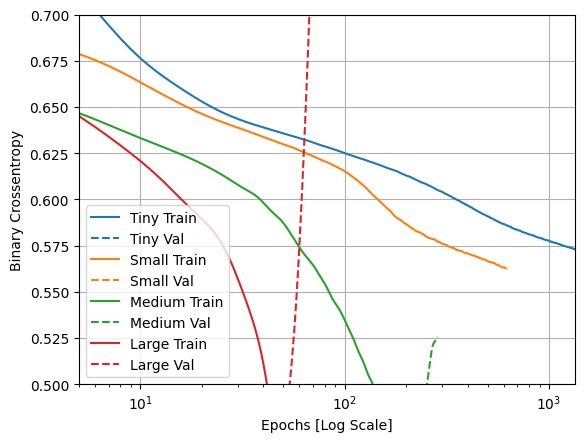

In [27]:
plotter.plot(size_histories)
a = plt.xscale("log")
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [30]:
# 과대적합을 방지하기 위해서
shutil.rmtree(logdir / "regularizers/Tiny", ignore_errors=True)
shutil.copytree(logdir / "sizes/Tiny", logdir / "regularizers/Tiny")

PosixPath('/tmp/tmp8qskxl7x/tensorboard_logs/regularizers/Tiny')

In [31]:
regularizer_histories = {}
regularizer_histories["Tiny"] = size_histories["Tiny"]

In [32]:
# l2 정규화를 사용
l2_model = tf.keras.Sequential(
    [
        layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=regularizers.l2(0.001),
            input_shape=(FEATURES,),
        ),
        layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation="elu", kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1),
    ]
)

regularizer_histories["l2"] = compile_and_fit(l2_model, "regularizers/l2")

/home/chan/code/vscode/tensor-cpp/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5114,  binary_crossentropy:0.8121,  loss:2.3273,  val_accuracy:0.4810,  val_binary_crossentropy:0.4719,  val_loss:2.1412,  
.

/home/chan/code/vscode/tensor-cpp/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


...................................................................................................
Epoch: 100, accuracy:0.6640,  binary_crossentropy:0.5936,  loss:0.6179,  val_accuracy:0.6470,  val_binary_crossentropy:0.3972,  val_loss:0.6200,  
....................................................................................................
Epoch: 200, accuracy:0.6741,  binary_crossentropy:0.5799,  loss:0.6035,  val_accuracy:0.6540,  val_binary_crossentropy:0.3871,  val_loss:0.6045,  
....................................................................................................
Epoch: 300, accuracy:0.6870,  binary_crossentropy:0.5735,  loss:0.5982,  val_accuracy:0.6780,  val_binary_crossentropy:0.3861,  val_loss:0.6038,  
....................................................................................................
Epoch: 400, accuracy:0.6953,  binary_crossentropy:0.5612,  loss:0.5874,  val_accuracy:0.6760,  val_binary_crossentropy:0.3837,  val_loss:0.6016,  
.........

(0.5, 0.7)

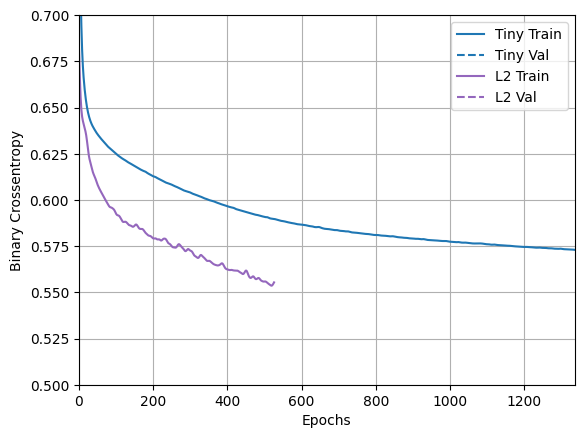

In [33]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [34]:
dropout_model = tf.keras.Sequential(
    [
        layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(1),
    ]
)

regularizer_histories["dropout"] = compile_and_fit(
    dropout_model, "regularizers/dropout"
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5010,  binary_crossentropy:0.8047,  loss:0.8047,  val_accuracy:0.4690,  val_binary_crossentropy:0.4521,  val_loss:0.6781,  
....................................................................................................
Epoch: 100, accuracy:0.6603,  binary_crossentropy:0.5929,  loss:0.5929,  val_accuracy:0.6890,  val_binary_crossentropy:0.3817,  val_loss:0.5725,  
....................................................................................................
Epoch: 200, accuracy:0.6861,  binary_crossentropy:0.5572,  loss:0.5572,  val_accuracy:0.6770,  val_binary_crossentropy:0.3855,  val_loss:0.5782,  
....................................................................................................
Epoch: 300, accuracy:0.7171,  binary_crossentropy:0.5111,  loss:0.5111,  val_accuracy:0.6970,  val_binary_crossentropy:0.4024,  val_loss:0.6036,  
...................................................................................

(0.5, 0.7)

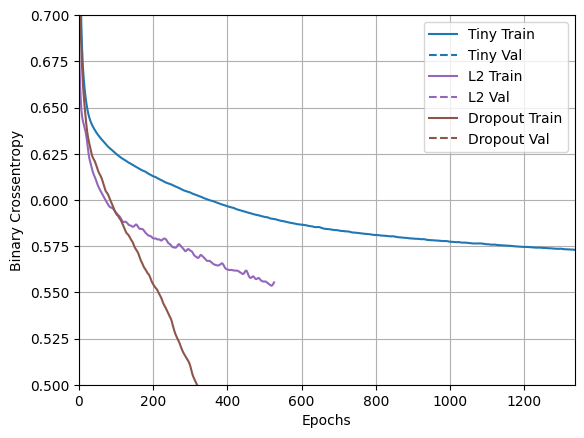

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [ ]:
combined_model = tf.keras.Sequential(
    [
        layers.Dense(
            512,
            kernel_regularizer=regularizers.l2(0.0001),
            activation="elu",
            input_shape=(FEATURES,),
        ),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="elu"),
        layers.Dropout(0.5),
        layers.Dense(1),
    ]
)

regularizer_histories["combined"] = compile_and_fit(
    combined_model, "regularizers/combined"
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)


Epoch: 0, accuracy:0.5125,  binary_crossentropy:0.7904,  loss:0.9488,  val_accuracy:0.4880,  val_binary_crossentropy:0.4546,  val_loss:0.8396,  
....................................................................................................
Epoch: 100, accuracy:0.6493,  binary_crossentropy:0.6052,  loss:0.6335,  val_accuracy:0.6440,  val_binary_crossentropy:0.3870,  val_loss:0.6086,  
....................................................................................................
Epoch: 200, accuracy:0.6676,  binary_crossentropy:0.5850,  loss:0.6106,  val_accuracy:0.6790,  val_binary_crossentropy:0.3815,  val_loss:0.5978,  
....................................................................................................
Epoch: 300, accuracy:0.6713,  binary_crossentropy:0.5819,  loss:0.6097,  val_accuracy:0.6800,  val_binary_crossentropy:0.3746,  val_loss:0.5898,  
....................................................................................................
Epoch: 40

2025-07-01 22:33:07.580709: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


........................................................................
Epoch: 800, accuracy:0.6846,  binary_crossentropy:0.5606,  loss:0.5962,  val_accuracy:0.6900,  val_binary_crossentropy:0.3633,  val_loss:0.5806,  
........................................

In [ ]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])